<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Импорт всех необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

Ознакомимся с датасетом

In [2]:
df = pd.read_csv('./Churn.csv')
df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Уберем ненужные для построения моделей столбцы

In [3]:
df.drop(columns=['Surname','RowNumber','CustomerId'],inplace=True)

In [4]:
df.isna().sum()
df.duplicated().sum()

0

In [5]:
df['Tenure'] = df['Tenure'].fillna(0)

In [6]:
df.columns = df.columns.str.lower()
df.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [7]:
df.dtypes

creditscore          int64
geography           object
gender              object
age                  int64
tenure             float64
balance            float64
numofproducts        int64
hascrcard            int64
isactivemember       int64
estimatedsalary    float64
exited               int64
dtype: object

Разделим Датасет на обучающую, валидационную и тестувую выборки

In [8]:
X = df.drop(['exited'], axis=1)
y = df['exited']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.6, test_size=0.4, random_state=12345)
X_test, X_valid, y_test, y_valid = train_test_split(X_valid, y_valid, test_size=0.5, random_state=12345)

print('Train set size:', X_train.shape[0])
print('Valid set size:', X_valid.shape[0])
print('Test set size:',X_test.shape[0])

Train set size: 6000
Valid set size: 2000
Test set size: 2000


Проведем кодирование с помощью OHE

In [9]:
X_train = pd.get_dummies(X_train,drop_first=True)
X_train.shape

(6000, 11)

In [10]:
X_valid = pd.get_dummies(X_valid,drop_first=True)
X_valid.shape

(2000, 11)

In [11]:
X_test = pd.get_dummies(X_test,drop_first=True)
X_test.shape

(2000, 11)

Стандартизируем признаки с помощью StandardScaler

In [12]:
numeric = ['creditscore', 'age', 'balance', 'estimatedsalary']
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])

scaler2 = StandardScaler()
scaler2.fit(X_valid[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])

scaler3 = StandardScaler()
scaler3.fit(X_test[numeric])
X_test[numeric] = scaler3.transform(X_test[numeric])

Выводы:

1)Изучили и подготовили наш датасет


2)Заполнили пропуски в столбце Tenure


3)Дубликатов не выявлено


4)Провели кодирование OHE и стандартизировали признаки с помощью StandardScaler


5)Разделили наш датасет на выборки - обучающую, валидационную и тестовую

## Исследование задачи

Протестируем модель RandomForestClassifier со стандартными параметрами, 
посмотрим какой Accuracy и f1score покажет нам модель

In [35]:
model = RandomForestClassifier(random_state=12345)
model.fit(X_train, y_train)
predicted_valid = model.predict(X_valid)
accuracy_valid = accuracy_score(predicted_valid, y_valid)
print('Accuracy is:', accuracy_valid)
print('F1_Score is:', f1_score(y_valid, predicted_valid))
confusion_matrix(y_valid, predicted_valid)

Accuracy is: 0.845
F1_Score is: 0.5303030303030303


array([[1515,   62],
       [ 248,  175]])

Протестируем модель LogisticRegression со стандартными параметрами, 
посмотрим какой Accuracy и f1score покажет нам модель

In [36]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(X_train, y_train)
predicted_valid = model.predict(X_valid)
accuracy_valid = accuracy_score(predicted_valid, y_valid)
print('Accuracy is:', accuracy_valid)
print('F1_Score is:', f1_score(y_valid, predicted_valid))

confusion_matrix(y_valid, predicted_valid)

Accuracy is: 0.791
F1_Score is: 0.2743055555555555


array([[1503,   74],
       [ 344,   79]])

Вывод: Модель Случайный лес показывает наилучшие результаты, попробуем ее улучшить 

## Борьба с дисбалансом

Попробуем через цикл подобрать более лучшие параметры случайного леса применив class_weight='balanced'

In [37]:
for depth,estimator in itertools.product(range(1,30,10), range(1,151,50)):
    model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=estimator, class_weight='balanced')
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    score = accuracy_score(predictions, y_valid)
    fscore = f1_score(y_valid, predictions)
    print('Depth: {: >5.0f}       |   Estimators: {:>5.0f}'.format(depth, estimator))
    print('Accuracy: {: >5.4f}   |   F1_Score: {: >5.4f}'.format(score,fscore))
    

Depth:     1       |   Estimators:     1
Accuracy: 0.8095   |   F1_Score: 0.2177
Depth:     1       |   Estimators:    51
Accuracy: 0.7355   |   F1_Score: 0.5187
Depth:     1       |   Estimators:   101
Accuracy: 0.7385   |   F1_Score: 0.5232
Depth:    11       |   Estimators:     1
Accuracy: 0.7525   |   F1_Score: 0.5281
Depth:    11       |   Estimators:    51
Accuracy: 0.8450   |   F1_Score: 0.6076
Depth:    11       |   Estimators:   101
Accuracy: 0.8430   |   F1_Score: 0.6025
Depth:    21       |   Estimators:     1
Accuracy: 0.7845   |   F1_Score: 0.4911
Depth:    21       |   Estimators:    51
Accuracy: 0.8455   |   F1_Score: 0.5282
Depth:    21       |   Estimators:   101
Accuracy: 0.8410   |   F1_Score: 0.5123


При глубине деревьев 11 и числе деревьев 51. F1_score показал наилучший результат : 0.6076 и accuracy_score : 0.8450. Попробуем улучшить показатели

In [38]:
#Попробуем обучить нашу модель с помощью увеличения выборки

def upsampling(features, target, repeat):
    X_zeros = X_train[y_train == 0]
    X_ones = X_train[y_train == 1]
    y_zeros = y_train[y_train == 0]
    y_ones = y_train[y_train == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=12345)
    
    return X_upsampled, y_upsampled


for repeat in range(1,10,1):
    X_upsampled, y_upsampled = upsampling(X_train, y_train, repeat)

    model = RandomForestClassifier(random_state=12345)
    model.fit(X_upsampled, y_upsampled)
    predictions = model.predict(X_valid)
    print("F1_Score: {: >5.3f}  |   Repeats : {: >5.0f}".format(f1_score(y_valid, predictions),repeat))

F1_Score: 0.541  |   Repeats :     1
F1_Score: 0.585  |   Repeats :     2
F1_Score: 0.574  |   Repeats :     3
F1_Score: 0.579  |   Repeats :     4
F1_Score: 0.587  |   Repeats :     5
F1_Score: 0.586  |   Repeats :     6
F1_Score: 0.588  |   Repeats :     7
F1_Score: 0.601  |   Repeats :     8
F1_Score: 0.582  |   Repeats :     9


In [39]:
#Попробуем обучить нашу модель с помощью уменьшения выборки

def downsampling(X, y, fraction):
    X_zeros = X[y == 0]
    X_ones = X[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    X_downsampled = pd.concat(
        [X_zeros.sample(frac=fraction, random_state=12345)] + [X_ones])
    y_downsampled = pd.concat(
        [y_zeros.sample(frac=fraction, random_state=12345)] + [y_ones])
    
    X_downsampled, y_downsampled = shuffle(
        X_downsampled, y_downsampled, random_state=12345)
    
    return X_downsampled, y_downsampled

for i in np.arange(0.03, 0.31, 0.03):
    X_downsampled, y_downsampled = downsampling(X_train, y_train, i)
    model = RandomForestClassifier(random_state=12345)
    model.fit(X_downsampled, y_downsampled)
    predictions = model.predict(X_valid)
    print("F1_Score: {: >5.3f}  |  Fractions : {: >5.3f}".format(f1_score(y_valid, predictions), i))

F1_Score: 0.370  |  Fractions : 0.030
F1_Score: 0.424  |  Fractions : 0.060
F1_Score: 0.479  |  Fractions : 0.090
F1_Score: 0.511  |  Fractions : 0.120
F1_Score: 0.540  |  Fractions : 0.150
F1_Score: 0.550  |  Fractions : 0.180
F1_Score: 0.562  |  Fractions : 0.210
F1_Score: 0.573  |  Fractions : 0.240
F1_Score: 0.588  |  Fractions : 0.270
F1_Score: 0.588  |  Fractions : 0.300


## Тестирование модели

Протестируем нашу модель на тестовой выборке с соответствующими параметрами

In [40]:
model = RandomForestClassifier(n_estimators = 51, max_depth=11, class_weight='balanced', random_state=12345)
model.fit(X_train, y_train)
predicted_valid = model.predict(X_test)

accuracy_valid = accuracy_score(predicted_valid, y_test)
print('Accuracy:', accuracy_valid)
print('F1_Score:', f1_score(y_test, predicted_valid))

Accuracy: 0.8465
F1_Score: 0.6069142125480155


Отрисуем ROC Кривую

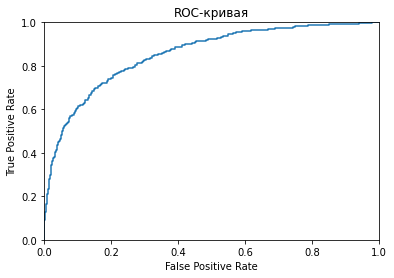

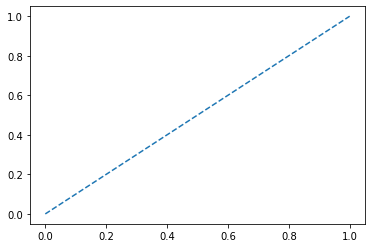

In [41]:
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid) 
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

plt.plot([0, 1], [0, 1], linestyle='--')

plt.show()

In [42]:
auc_roc = roc_auc_score(y_valid, probabilities_one_valid)
print(f'ROC AUC SCORE is: {auc_roc}')

ROC AUC SCORE is: 0.8540500186636806


Выводы:

1)Подготовили датасет для прогнозирования оттока клиентов


2)Использовали RandomForestClassifier и LogisticRegression, выбрали RandomForestClassifier для дальнейшей работы.


3)Для увеличения f1_score, мы попробовали увеличить и уменьшить выборки, получили это f1_score : 0.56. 


4)Применив метод подбора гиперпараметров через цикл мы нашли наилучшие параметры для Случайного Леса и получили F1_score : 0.62


5)Отрисовали ROC кривую и получили roc auc score : 85, что значительно выше случайного порога в 0.5. Наша модель предсказывает достаточно хорошо.